In [1]:
import xarray as xr 
import xcast as xc 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from cartopy import feature 
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')

In [2]:
x = xr.open_dataset('sascof_x.nc').prec
y = xr.open_dataset('sascof_y.nc').expand_dims({'M':['SASCOF DATA']}).rf
f = xr.open_dataset('sascof_f.nc').prec

In [3]:
x = xc.regrid(x, y.coords['LONGITUDE'].values, y.coords['LATITUDE'].values)
f = xc.regrid(f, y.coords['LONGITUDE'].values, y.coords['LATITUDE'].values)

### Climatology

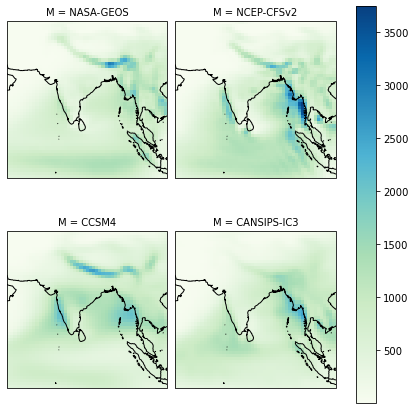

In [4]:
xplot = x.mean('S').plot(col='M', col_wrap=2, subplot_kws={'projection': ccrs.PlateCarree()},  cmap='GnBu',  figsize=(6, 6))
for ax in xplot.axes.flat:
    ax.coastlines()


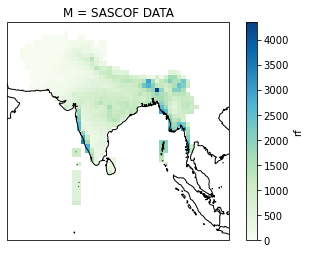

In [5]:
yplot = y.mean('time').plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='GnBu', vmin=0)
art = yplot.axes.coastlines()

### Forecast Inputs

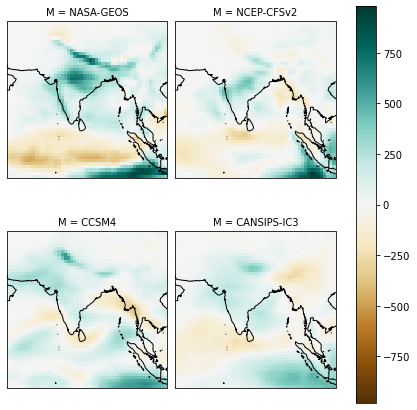

In [6]:
fplot = (f - x.mean('S')).plot(col='M', col_wrap=2, subplot_kws={'projection': ccrs.PlateCarree()}, cmap='BrBG',  figsize=(6, 6))
for ax in fplot.axes.flat:
    ax.coastlines()

### Cross Validation

In [63]:
ND=30
hidden_layer_size = 5
activation = 'relu'
crossvalidation_window = 3
preprocessing='minmax'

In [64]:
poelm_xval = []
elm_xval = []
i = 1
start = pd.Timestamp.now()
for x_train, y_train, x_test, y_test in xc.CrossValidator(x, y, window=crossvalidation_window):
    ohc = xc.RankedTerciles()
    ohc.fit(y_train)
    ohc_y_train = ohc.transform(y_train)
    
    y_train = y_train - y_train.mean('time')

    poelm = xc.cPOELM(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
    poelm.fit(x_train, ohc_y_train, rechunk=False)
    poelm_preds = poelm.predict_proba(x_test, rechunk=False)
    poelm_xval.append(poelm_preds.isel(S=crossvalidation_window // 2))
    
    elm = xc.rExtremeLearningMachine(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
    elm.fit(x_train, y_train, rechunk=False)
    elm_preds = elm.predict(x_test, rechunk=False)
    elm_xval.append(elm_preds.isel(S=crossvalidation_window // 2))
    print('Fit Window {}/38 - {}'.format(i, pd.Timestamp.now() - start), end='\r')
    i+= 1
poelm_hcst = xr.concat(poelm_xval, 'S').mean('ND')
elm_hcst = xr.concat(elm_xval, 'S').mean('ND')

### Calculate Skill

In [69]:
sascof_encoder = xc.RankedTerciles()
sascof_encoder.fit(y)
sascof_ohc = sascof_encoder.transform(y)

groc = xc.GeneralizedROC(poelm_hcst, sascof_ohc)
poelm_rps = xc.RankProbabilityScore(poelm_hcst, sascof_ohc)
climatological_odds = xr.ones_like(poelm_hcst) * 0.33 
climo_rps = xc.RankProbabilityScore(climatological_odds, sascof_ohc)
rpss = 1 - ( poelm_rps / climo_rps)

pearson = xc.Pearson(elm_hcst, y)
ioa = xc.IndexOfAgreement(elm_hcst, y)


### Plot Skill

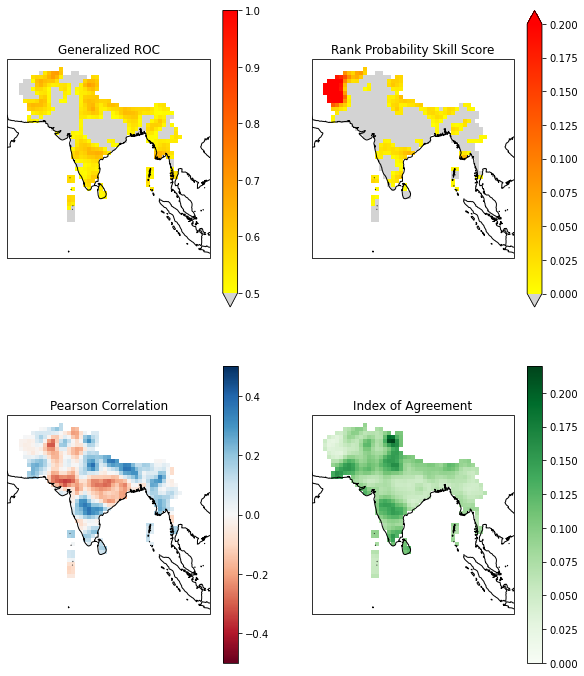

In [70]:
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature

cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

groc_smooth = xc.gaussian_smooth(groc, kernel=(3,3))
rpss_smooth = xc.gaussian_smooth(rpss, kernel=(3,3))
pearson_smooth = xc.gaussian_smooth(pearson, kernel=(3,3))
ioa_smooth = xc.gaussian_smooth(ioa, kernel=(3,3))


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 12), subplot_kw={'projection': ccrs.PlateCarree()})
groc_smooth.plot(ax=ax[0][0], vmin=0.5, vmax=1, cmap=cmap)
ax[0][0].coastlines()
t = ax[0][0].set_title('Generalized ROC')

rpss_smooth.plot(ax=ax[0][1], vmin=0, vmax=0.2, cmap=cmap)
ax[0][1].coastlines()
t = ax[0][1].set_title('Rank Probability Skill Score')

pearson_smooth.plot(ax=ax[1][0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1][0].coastlines()
t = ax[1][0].set_title('Pearson Correlation')

ioa_smooth.plot(ax=ax[1][1],  cmap='Greens', vmin=0)
ax[1][1].coastlines()
t = ax[1][1].set_title('Index of Agreement')



### Forecasts

In [79]:
poelm_forecaster = xc.cPOELM(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
poelm_forecaster.fit(x, sascof_ohc)
probabilistic_forecast = poelm_forecaster.predict_proba(f).mean('ND')


elm_forecaster = xc.rExtremeLearningMachine(ND=ND, hidden_layer_size=hidden_layer_size, activation=activation, preprocessing=preprocessing)
elm_forecaster.fit(x, y - y.mean('time'))
deterministic_forecast = elm_forecaster.predict(f).mean('ND')

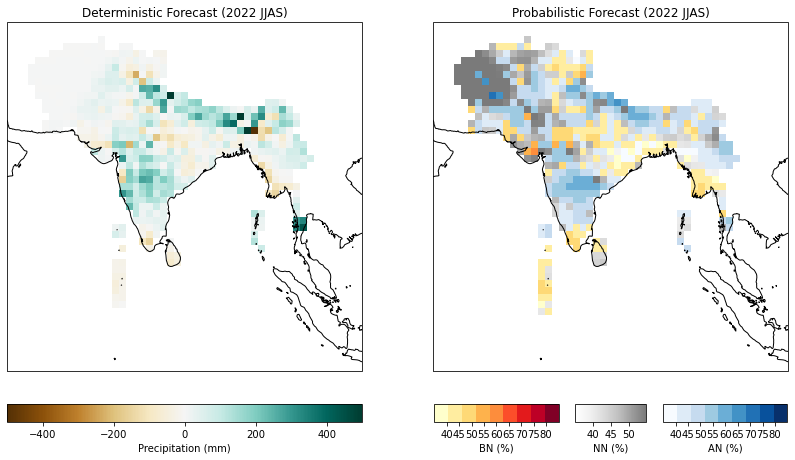

In [108]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
graycmap = truncate_colormap(plt.get_cmap('Greys'),0.0, 0.6 )
graycmap = plt.get_cmap(graycmap, 4)

deterministic_forecast_smooth = xc.gaussian_smooth(deterministic_forecast, kernel=(3,3))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})
CS = deterministic_forecast.isel(M=0, S=0).plot(ax=ax[0], add_colorbar=False, vmin=-500, vmax=500,  cmap='BrBG')
ax[0].coastlines()
t = ax[0].set_title('Deterministic Forecast (2022 JJAS)')
axins_det = inset_axes(ax[0],width="100%",  height="5%",  loc='lower center', bbox_to_anchor=(-0, -0.15, 1, 1), bbox_transform=ax[0].transAxes, borderpad=0.1 )
cbar_fbl = fig.colorbar(CS, ax=ax[0], cax=axins_det, orientation='horizontal')
cbar_fbl.set_label('Precipitation (mm)')

bounds = [40,45,50,55,60,65,70,75,80]
nbounds = [40,45,50]
mask = probabilistic_forecast.mean('M').mean('S')
mask = mask.where(np.isnan(mask), other=1)
argmax = probabilistic_forecast.fillna(-999).argmax('M') * mask

argmax_smooth = xc.gaussian_smooth(argmax.expand_dims({'M':[0]}), kernel=(3,3)).mean('M').mean('S')
argmax_nn = argmax_smooth.where(argmax_smooth < 1.33, other=np.nan)
argmax_nn = argmax_nn.where(argmax_nn > 0.66, other=np.nan)

flat = mask.where(argmax != 2, other=probabilistic_forecast.isel(M=2))
flat = flat.where(argmax != 1, other=probabilistic_forecast.isel(M=1))
flat = flat.where(argmax != 0, other=probabilistic_forecast.isel(M=0)) * mask 
flat = xc.gaussian_smooth(flat.expand_dims('M'), kernel=(3,3))

#CS3 = probabilistic_forecast.isel(M=2).where(argmax == 2, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
#CS1 = probabilistic_forecast.isel(M=0).where(argmax == 0, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('YlOrRd', 9))
#CS2 = probabilistic_forecast.isel(M=1).where(argmax == 1, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap(graycmap, 4))

#CS3 = probabilistic_forecast.isel(M=2).where(argmax_smooth > 1.33, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
#CS1 = probabilistic_forecast.isel(M=0).where(argmax_smooth <= 0.66, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('YlOrRd', 9))
#CS2 = probabilistic_forecast.isel(M=1).where(argmax_nn > 0 , other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap(graycmap, 4))

#CS3 = flat.where(argmax_smooth > 1.33, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
#CS1 = flat.where(argmax_smooth <= 0.66, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('YlOrRd', 9))
#CS2 = flat.where(argmax_nn > 0 , other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap(graycmap, 4))

CS3 = flat.where(argmax == 2, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
CS1 = flat.where(argmax == 0, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('YlOrRd', 9))
CS2 = flat.where(argmax == 1, other=np.nan).plot(ax=ax[1], add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap(graycmap, 4))


ax[1].coastlines()
t = ax[1].set_title('Probabilistic Forecast (2022 JJAS)')
axins_f_bottom = inset_axes(ax[1], width="35%", height="5%", loc='lower left', bbox_to_anchor=(-0, -0.15, 1, 1), bbox_transform=ax[1].transAxes,borderpad=0.1 )
axins2_bottom = inset_axes(ax[1], width="20%",  height="5%", loc='lower center', bbox_to_anchor=(-0.0, -0.15, 1, 1), bbox_transform=ax[1].transAxes, borderpad=0.1 )
axins3_bottom = inset_axes(ax[1], width="35%",  height="5%", loc='lower right', bbox_to_anchor=(0, -0.15, 1, 1), bbox_transform=ax[1].transAxes, borderpad=0.1 )

cbar_fbl = fig.colorbar(CS1, ax=ax[1], cax=axins_f_bottom, orientation='horizontal')
cbar_fbl.set_label('BN (%)') 
cbar_fbl.set_ticks([i /100.0 for i in bounds])
cbar_fbl.set_ticklabels(bounds)


cbar_fbc = fig.colorbar(CS2, ax=ax[1],  cax=axins2_bottom, orientation='horizontal')
cbar_fbc.set_label('NN (%)') 
cbar_fbc.set_ticks([i /100.0 for i in nbounds])
cbar_fbc.set_ticklabels(nbounds)

cbar_fbr = fig.colorbar(CS3, ax=ax[1],  cax=axins3_bottom, orientation='horizontal')
cbar_fbr.set_label('AN (%)') 
cbar_fbr.set_ticks([i /100.0 for i in bounds])
cbar_fbr.set_ticklabels(bounds)
